In [1]:

import pandas as pd
import numpy as np 
import re , datetime , logging, pickle, os
from lib.config import connstr
from lib.utils import * 
from lib.question_type_recommender import question_type_recommender
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore') 
from sklearn.linear_model import Ridge, Lasso
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression 
from sklearn import svm
import shap 

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from lib.context import context
ctx=context() 
ctx.logger.setLevel(logging.DEBUG)
config = {}
with open('config.json', 'r') as f: 
    config=json.loads(f.read())    
ctx.config=config 

In [ ]:
qr = question_type_recommender(ctx, verbose=True, use_cache=True)
qr.recommend('How many threat model exercises [34] were conducted in the last reporting period ?')

In [2]:
sns.set(rc={'figure.figsize':(18,4.7)}) 
plt.style.use('Solarize_Light2') # fivethirtyeight

In [ ]:
codes = ['YN','CNT','TXT','PICK','FREQ','DEC','MULTICHECKBOX' ]
qt=sql_todf(f"""
SELECT PK_QuestionTypeId, Code ,description FROM fsma_QuestionTypes
  WHERE Code IN ('YN','CNT','YNA','TXT','PICK','LABEL','FREQ','DEC','MULTICHECKBOX')
    """, connstr)   

df=sql_todf(f"""
    SELECT PK_Question, FK_QuestionType, Code, QuestionText 
    FROM fsma_Questions 
	  INNER JOIN fsma_QuestionTypes ON fsma_Questions.FK_QuestionType=fsma_QuestionTypes.PK_QuestionTypeId
	  WHERE FK_QuestionType IS NOT NULL AND QuestionText IS NOT NULL  
    AND Code IN ('{"','".join(codes)}')  
    AND PK_Question < 40000
    ORDER BY PK_QUESTION DESC
    """, connstr)  

def _normalizer(s):
    s=re.sub('[^a-z0-9\s\-\?]','',s.lower() )
    s=re.sub('\s{2,}',' ',s).strip()
    return s 
#_normalizer('How many threat model exercises [34] were conducted in the last reporting period ?')
#qt
# df[df['Code'].isin(['FREQ','DEC'])]

In [ ]:
sns.barplot(df['Code'].value_counts().index, df['FK_QuestionType'].value_counts().values, alpha=0.6) 

In [ ]:
 
df['QuestionText']=df['QuestionText'].apply(_normalizer)  
model = LogisticRegression()
lod=[]
for ng in [ (1,2) ]: # ,  , (1,3), (1,4) (1,2), 
    for i in range(3,4,1): # 0.002
        start = datetime.datetime.now()
        mindf = i*.001   
        vectorizer = CountVectorizer(ngram_range=ng, min_df=mindf, stop_words=['in'], analyzer='word',token_pattern=u'\w+|\?')
        
        X = vectorizer.fit_transform(df['QuestionText'])   
        sparse_matrix = pd.DataFrame(columns=vectorizer.get_feature_names(), data=X.toarray()) 
        sparse_matrix=pd.merge(df, sparse_matrix, left_index=True, right_index=True)  
        sparse_matrix.drop(['QuestionText', 'PK_Question', 'Code' ], inplace=True, axis=1) 
        y = sparse_matrix['FK_QuestionType'].values 
        X = sparse_matrix.drop(['FK_QuestionType' ], axis=1).values
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
        model.fit(X_train, y_train)
        y_pred=model.predict(X_test)
        score=model.score(X_test, y_test) 
        stop = datetime.datetime.now()
        report = classification_report(y_test, y_pred, target_names=codes)
        d={
            'score':score,
            'time': (stop-start).seconds,
            'ngram_range': ng,
            'min_df': mindf,
            'sparse_matrix.shape':sparse_matrix.shape,
            'report':report
        }
        print(d)  
        lod.append(d)
scores = pd.DataFrame(lod)

In [ ]:
print( scores.loc[0, 'report'] )  
scores.sort_values(by='score')
if len(scores) > 1:
    sns.lineplot(data=scores, x='time', y='score' )

In [ ]:
coefficients = abs(model.coef_[0])
coefficients[0]
fi = pd.DataFrame({'Feature': sparse_matrix.columns[1:], 'Importance': coefficients})
fi = fi.sort_values('Importance', ascending=False)   
plot = sns.barplot(x=fi[:50].Feature , y=fi[:50].Importance) 
plt.xticks(rotation=90)
plt.show() 

In [ ]:
explainer = shap.Explainer(model, X_test )
shap_values = explainer.shap_values(X_test)   
shap.summary_plot( shap_values,  X_test, max_display=25,  feature_names=sparse_matrix.columns[1:],  plot_size=[18,16] ) 

In [ ]:

df1=sql_todf(f"""
    SELECT  FK_QuestionType, Code, QuestionText 
    FROM fsma_Questions 
	  INNER JOIN fsma_QuestionTypes ON fsma_Questions.FK_QuestionType=fsma_QuestionTypes.PK_QuestionTypeId
	  WHERE FK_QuestionType IS NOT NULL AND QuestionText IS NOT NULL  
    AND Code IN ('YN', 'CNT', 'TXT', 'PICK', 'FREQ', 'DEC', 'MULTICHECKBOX') --  'YNA', 'FREQ','DEC',
    AND PK_Question > 40000
    ORDER BY PK_QUESTION DESC
    """, connstr)
print(codes)

In [ ]:
lod=[]
for i,r in df1.iterrows():
    rec = qr.recommend(r['QuestionText'])
    if str(r['FK_QuestionType']) != str(rec):
        d={
            'actual': r['FK_QuestionType'],
            'rec': rec,
            'QuestionText': r['QuestionText']
        }
        lod.append(d)
dff=pd.DataFrame(lod)


In [ ]:
d17 = dff.loc[dff.actual == 17]
d17.to_csv('out/data.csv')

In [ ]:
txt=_normalizer('How many threat model exercises [34] were conducted in the last reporting period ?')
print(txt)
X = vectorizer.transform([txt])  
prediction=model.predict(X.toarray())
print ('\nPK_QuestionType : '+ str(prediction[0])) 

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred) 
fig, ax = plt.subplots()
tick_marks = np.arange(len(codes))
plt.xticks(tick_marks, codes)
plt.yticks(tick_marks, codes) 
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, fmt='g' , xticklabels=codes, yticklabels=codes) 
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
def sm_predict(s,threshold=.25): 
    s=_normalizer(s)
    print ( s )
    dfff=df.copy()
    for i,r in dfff.iterrows():  
        normed = _normalizer(r['QuestionText'] )
        ratio=SequenceMatcher(None, s, normed).ratio() 
        dfff.loc[i, 'ratio'] = ratio
        #if ratio > threshold: break
    d=dfff.loc[dfff.ratio > threshold]
    d=d.sort_values(by=['ratio'], ascending=False) 
    return d
dfp=sm_predict("""

   Is there an internet-facing method to access the system?
    """)
dfp

In [24]:
import nltk
from nltk.stem import PorterStemmer
ps = PorterStemmer()

def _normalizer(s):
    s=re.sub('[^a-z0-9\s\-\?]','',s.lower().strip() )
    s=re.sub('\s{2,}',' ',s)
    s=' '.join([ ps.stem(s) for s in s.split(' ')])
    return s 
_normalizer('Has the Agency implemented an automated capability to detect and block unauthorized hardware from connecting to the network?' )

'ha the agenc implement an autom capabl to detect and block unauthor hardwar from connect to the network?'

In [60]:
df=sql_todf(f"""
    SELECT  QuestionText, CAST(FK_PickListType AS NVARCHAR(9)) Y -- FK_QuestionType, Code, 
    FROM fsma_Questions 
	  INNER JOIN fsma_QuestionTypes ON fsma_Questions.FK_QuestionType=fsma_QuestionTypes.PK_QuestionTypeId
	  WHERE FK_QuestionType IS NOT NULL AND QuestionText IS NOT NULL  
    AND Code IN ( 'PICK',  'MULTICHECKBOX') 
    AND FK_PickListType IN (124,157,162,168,330,423,85,88,89,97)
    ORDER BY PK_QUESTION DESC
    """, connstr)
df['QuestionText']=df['QuestionText'].apply(_normalizer)
df=df.sort_values('QuestionText').drop_duplicates(subset=['Y', 'QuestionText'], keep='last')
pk1=df[:-500]
pk2=df[500:]
df


,QuestionText,Y
1194,all user are uniqu identifi and authent for re...,89
922,approxim how mani high valu asset receiv banal...,124
920,approxim how mani high valu asset receiv binci...,124
924,approxim how mani high valu asset receiv bsecu...,124
918,approxim how mani high valu asset receiv bsitu...,124
...,...,...
134,when avail are all applic deploy in the hva pr...,423
124,when avail are product hva applic configur bas...,423
242,when possibl are hva asset procur from an appr...,423
506,when purchas hva or support infrastructur netw...,423


In [74]:
vectorizer = CountVectorizer(ngram_range=(1,3), min_df=.0001, stop_words='english', analyzer='word' ) 
X = vectorizer.fit_transform(df['QuestionText'])   
vectorizer.get_feature_names() 
X 

<1068x17986 sparse matrix of type '<class 'numpy.int64'>'
	with 59766 stored elements in Compressed Sparse Row format>

In [75]:
sparse_matrix = pd.DataFrame(columns=vectorizer.get_feature_names(), data=X.toarray()) 
sparse_matrix=pd.merge(df, sparse_matrix, left_index=True, right_index=True)  
sparse_matrix.drop(['QuestionText'], inplace=True, axis=1) 
y = sparse_matrix['Y'].values 
features = sparse_matrix.drop(['Y'], axis=1).values
X_train, X_test, y_train, y_test = train_test_split(features, y, random_state=1)

In [78]:
from sklearn import svm
model= LogisticRegression()
# model = svm.SVC()
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
score=model.score(X_test, y_test) 
report = classification_report(y_test, y_pred )


In [79]:
print(score)
print ( report ) 

0.7589285714285714
              precision    recall  f1-score   support

         124       1.00      0.40      0.57         5
         157       0.00      0.00      0.00         4
         162       1.00      0.17      0.29         6
         330       0.88      0.50      0.64        14
         423       0.72      0.93      0.82       107
          85       0.80      0.71      0.75        84
          89       0.00      0.00      0.00         1
          97       0.00      0.00      0.00         3

    accuracy                           0.76       224
   macro avg       0.55      0.34      0.38       224
weighted avg       0.75      0.76      0.73       224



In [71]:
txt=_normalizer("Did you evaluate iDP sources as described in the guidance? Did you harden SSO feature as described in the guidance? Did you turn on advanced logging and establish a PAM baseline(Expected privileged account state) for Cloud?")
print(txt)
X = vectorizer.transform([txt])  
prediction=model.predict(X.toarray())
print ('\nprediction: '+ str(prediction[0])) 



did you evalu idp sourc as describ in the guidance? did you harden sso featur as describ in the guidance? did you turn on advanc log and establish a pam baselineexpect privileg account state for cloud?

prediction: 423


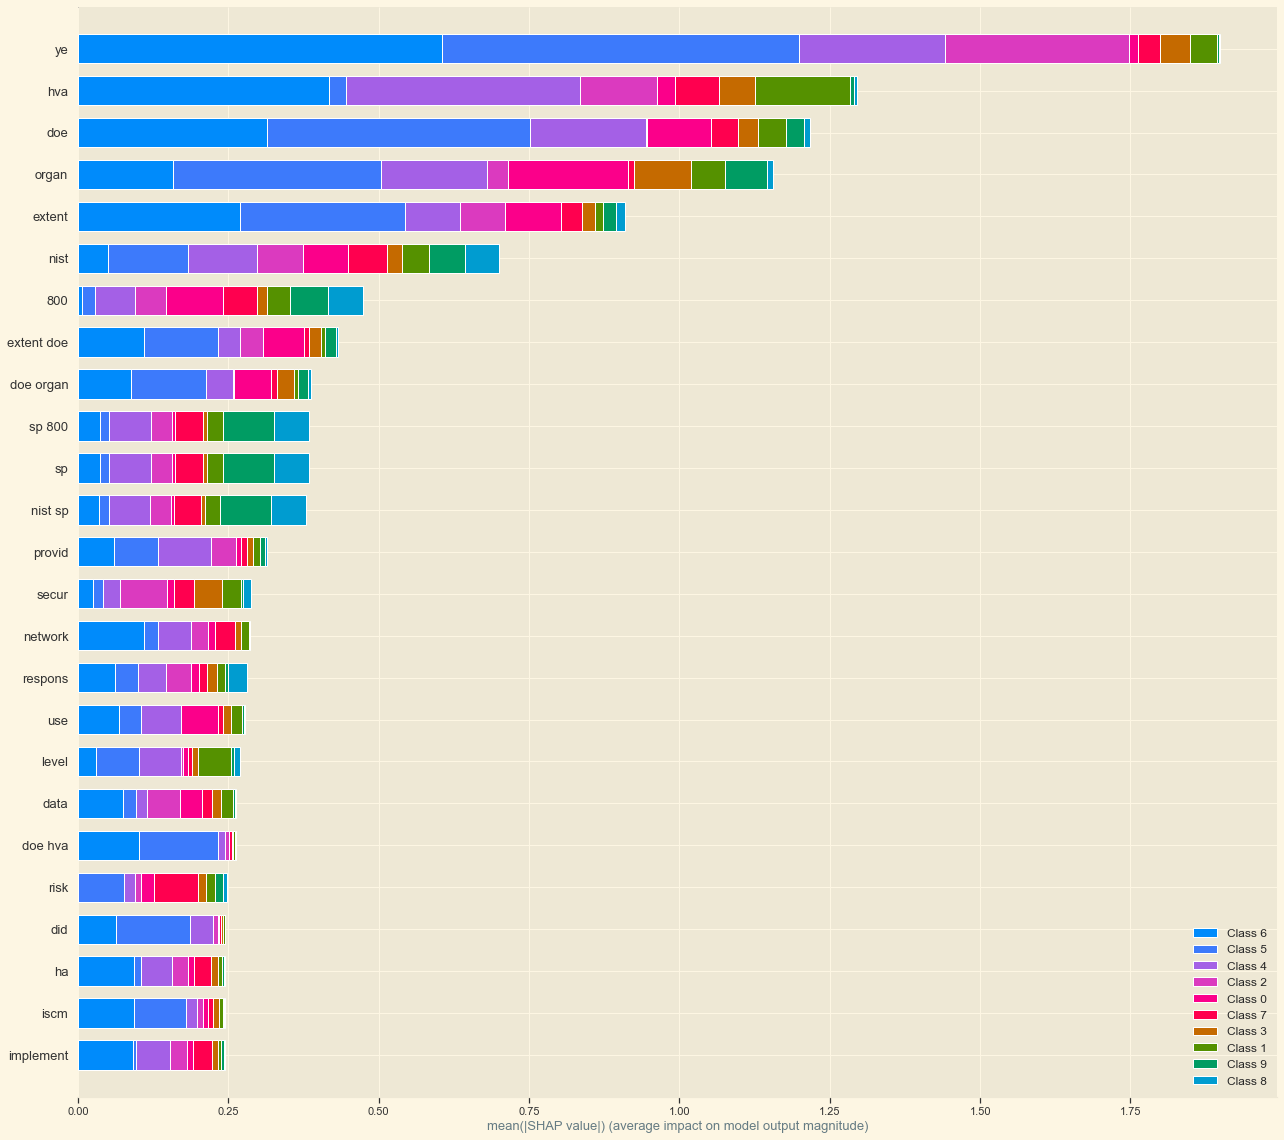

In [66]:
explainer = shap.Explainer(model, X_test )
shap_values = explainer.shap_values(X_test)   
shap.summary_plot( shap_values,  X_test, max_display=25,  feature_names=sparse_matrix.columns[1:],  plot_size=[18,16] ) 